In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from random import randint
from scipy import stats
from IPython import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.colors as mcolors
from scipy import ndimage
import matplotlib.path as mpath
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from random import randint
from scipy import optimize
import cv2


In [4]:
# ASSIGN LATER TO DATA LOADING FUNCTIONS

def load_specific_experiment_data(subject_id, date):
    # Load only specified components
    data = load_data(
    subject=subject_id,
    expDate=date,
    data_name_dict= 'all-default',
    )
        
    return data

def get_experiment_path(data):
    exp_idx = data.index[data.expDef.isin(['spontaneousActivity'])][0]
    exp_folder = data.loc[exp_idx, 'expFolder']
    exp_num = data.loc[exp_idx, 'expNum']
    return exp_folder, exp_num

def get_timestamps(exp_kwargs, rigName='poppy-stim'):
    data_name_dict = {'topCam':{'camera':['times','ROIMotionEnergy']}}
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    timestamps = stim_recordings['topCam'].iloc[0]['camera'].times
    start_time = np.where(timestamps >=0)[0][0]
    timestamps[:start_time] = np.nan
    timestamps = timestamps.flatten()
    
    return start_time, timestamps

def get_DLC_data (subject_id, date, start_time):
        dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
        dlc_df = dlc_df.iloc[start_time:]
        scorer = dlc_df.columns.get_level_values('scorer')

        return dlc_df, scorer

def load_spikes(exp_kwargs, rigName='poppy-stim'):
    ephys_dict = {'spikes':'all','clusters':'all'}
    # both probes 
    data_name_dict = {'probe0':ephys_dict,'probe1':ephys_dict}
    
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    
    # Try to get probe0 data - using dictionary-style access
    try:
        spikes_0 = stim_recordings['probe0'].iloc[0]['spikes']['times'] 
        clusters_0 = stim_recordings['probe0'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_0 = None
        clusters_0 = None
    
    # Try to get probe1 data - using dictionary-style access
    try:
        spikes_1 = stim_recordings['probe1'].iloc[0]['spikes']['times']  
        clusters_1 = stim_recordings['probe1'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_1 = None
        clusters_1 = None
    
    return spikes_0, clusters_0, spikes_1, clusters_1


In [5]:
# ASSIGN LATER TO VELOCITY CALCULATIONS (PART CALC VELOCITY AND WHEEL VELOCITY)
BODYPARTS = ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3']
def calculate_median_position(dlc_df, scorer):


    # Group by bodyparts and filter for only the ones we want to use in our calculation
    selected_data = dlc_df.loc[:, (scorer, BODYPARTS, slice(None))]
    

    # Select Values of High Quality
    likelihood_values = selected_data.xs('likelihood', level='coords', axis=1)
    likelihood_values[likelihood_values <= 0.95] = np.nan
    likelihood_values = likelihood_values.interpolate(method='linear')
    strong_xs = selected_data.xs('x', level='coords', axis=1)
    strong_ys = selected_data.xs('y', level='coords', axis=1)
    x_medians = strong_xs.median(axis=1)
    y_medians = strong_ys.median(axis=1)
   
    median_position = {idx: {'x': x, 'y': y} for idx, (x, y) in enumerate(zip(x_medians, y_medians))}
    median_position_df = pd.DataFrame.from_dict(median_position, orient='index')
    return median_position_df, x_medians, y_medians

def bin_median_positions(x_medians, y_medians,timestamps, start_time, bin_centers): 
    binned_x_medians = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(x_medians)), x_medians)
    binned_y_medians = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(y_medians)), y_medians)
    binned_median_positions = np.column_stack((binned_x_medians, binned_y_medians))
    return binned_x_medians, binned_y_medians, binned_median_positions
    

def calculate_velocity(binned_median_positions, bin_width):
    # Calculate the velocity using the binned median positions
    distances = np.sqrt(np.diff(binned_median_positions, axis=0)**2).sum(axis=1)
    max_distance = np.percentile(distances, 99)  
    distances[distances > max_distance] = np.nan
    valid_indices = np.where(~np.isnan(distances))[0]
    distances = np.interp(
    np.arange(len(distances)),  
    valid_indices,              
    distances[valid_indices]    
)
    velocity_pix = distances / bin_width
    conversion_factor = 0.0917 
    velocity = velocity_pix * conversion_factor
    velocity = gaussian_filter1d(velocity, 5)
    velocity = np.concatenate(([velocity[0] if len(velocity) > 0 else 0], velocity)) 
    return velocity

def get_rotary_metadata(exp_folder, bin_centers):
        try:
            TICKS_PER_CYCLE = 1024
            rotary = np.load(os.path.join(exp_folder, 'rotaryEncoder.raw.npy'), allow_pickle=True)
            rotary = rotary.flatten()
            rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
            
            timeline_file = glob.glob(os.path.join(exp_folder, f'*_Timeline.mat'))[0]   
            time = loadmat(timeline_file)
            rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
            rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)
            unwrapped_rotary_position = np.unwrap(rotary_position * np.pi/180) * 180/np.pi 
            binned_rotary_position = np.interp(bin_centers,rotary_timestamps, unwrapped_rotary_position)

            return rotary_timestamps, binned_rotary_position
            

        except Exception as e:
            print(f"Error accessing {exp_folder}: {e}")
            
        return None, None

def calculate_wheel_velocity(binned_rotary_position, bin_width, wheel_diameter=10):
    wheel_circumference = np.pi * wheel_diameter
    linear_distance_cm = np.diff(binned_rotary_position) * wheel_circumference / 360 
    wheel_velocity = np.abs(linear_distance_cm / bin_width) 
    wheel_velocity = gaussian_filter1d(wheel_velocity, 5)
    wheel_velocity = np.concatenate(([wheel_velocity[0] if len(wheel_velocity) > 0 else 0], wheel_velocity))
    return wheel_velocity


        
     





In [43]:
# WORK IN PROGRESS


def get_spike_hist(spike_times, spike_clusters,time_bins):

    spike_counts, _, _ = np.histogram2d(
        spike_clusters, 
        spike_times,
        bins=[np.arange(0, len(np.unique(spike_clusters))+1), time_bins],
        )
    return spike_counts





def plot_time_series(spike_counts, T_START=0, T_END=1600):
    plt.figure(figsize=(20, 8))
    plt.imshow(spike_counts[:,T_START:T_END], aspect='auto', vmax=np.percentile(spike_counts, 90))
    plt.xlabel('Time Bins')
    plt.ylabel('Neuron ID')
    plt.title('Time Series')

def filter_spike_counts(spike_counts, arena_mask, wheel_mask):
     arena_var = np.var(spike_counts[:, arena_mask], axis=1)
     wheel_var = np.var(spike_counts[:, wheel_mask], axis=1)

     zero_var = (arena_var == 0) | (wheel_var == 0)
     spike_counts_filtered = spike_counts[~zero_var, :]

     return spike_counts_filtered

def get_correlations(spike_counts_filtered, velocity, wheel_velocity, novel_arena_mask, novel_wheel_mask):
    arena_corrs = np.zeros(spike_counts_filtered.shape[0])
    wheel_corrs = np.zeros(spike_counts_filtered.shape[0])

    for i in range(spike_counts_filtered.shape[0]):
    # Free running correlation
        arena_corrs[i] = np.corrcoef(velocity[novel_arena_mask], spike_counts_filtered[i, novel_arena_mask])[0, 1]
        
        # Wheel running correlation
        wheel_corrs[i] = np.corrcoef(wheel_velocity[novel_wheel_mask], spike_counts_filtered[i, novel_wheel_mask])[0, 1]

    corrs_nan =  np.isnan(wheel_corrs) | np.isnan(arena_corrs)
    wheel_corrs = wheel_corrs[~corrs_nan]
    arena_corrs = arena_corrs[~corrs_nan]

    return arena_corrs, wheel_corrs

def plot_correlation_histogram(corrs):
    plt.figure(figsize=(12, 6))
    plt.hist(corrs, bins= 100, alpha=0.7)
    plt.xlabel('Correlation Coefficient', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks( fontsize=16)
    plt.yticks( fontsize=16)
    plt.show()

def plot_spike_counts_velocity_sorted(correlation, binned_velocity, binned_wheel_velocity, pos_wheel_mask, pos_arena_mask, spike_counts_filtered, T_START=0, T_END=1500):
     # Sort neurons by correlation
    sorted_indices = np.argsort(correlation)[::-1]
    sorted_spike_counts = spike_counts_filtered[sorted_indices[:10], :]
    
    # Prepare velocity data for plotting
    vel_plot = binned_velocity.copy()
    vel_plot[pos_wheel_mask] = np.nan
    
    wheel_plot = binned_wheel_velocity.copy()
    wheel_plot[pos_arena_mask] = np.nan
    
    # Create figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12), 
                                       gridspec_kw={'height_ratios': [1, 1, 3]},
                                       sharex=True)
    
    # Plot velocities
    ax1.plot(vel_plot[T_START:T_END], color='green', alpha=0.8)
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
   #ax1.set_ylabel('Free Running Velocity (cm/s)', color='green')

    ax2.plot(wheel_plot[T_START:T_END], color='purple', alpha=0.8)
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    #ax2.set_ylabel('Wheel Running Velocity (cm/s)', color='purple')

    arena_counts = np.zeros_like(sorted_spike_counts)
    wheel_counts = np.zeros_like(sorted_spike_counts)

    # Fill in spike counts for each context
    arena_counts[:, pos_arena_mask] = sorted_spike_counts[:, pos_arena_mask]
    wheel_counts[:, pos_wheel_mask] = sorted_spike_counts[:, pos_wheel_mask]


    # Plot arena counts in green
    ax3.imshow(arena_counts[:, T_START:T_END], cmap='Greens', aspect='auto', alpha=1,  vmax = np.percentile(spike_counts_filtered, 95))

    # Plot wheel counts in purple on top
    ax3.imshow(wheel_counts[:, T_START:T_END], cmap='Purples', aspect='auto',alpha=0.7,  vmax = np.percentile(spike_counts_filtered, 95))

    ax3.set_yticks([])
    ax3.set_yticklabels([])
    #ax3.text(0.5, -0.05, '1 min', transform=ax3.transAxes, 
        #ha='center', va='top', fontsize=10)
    #ax3.set_xlabel('Time Bins')
    #ax3.text(-0.05, 0.5, '500 neurons', transform=ax3.transAxes, 
        #ha='right', va='center', fontsize=10, rotation=90)
    #ax3.set_ylabel('Neurons (sorted by correlation)')

    plt.tight_layout()
    plt.show()
    
    

    plt.tight_layout()



def plot_wheel_arena_corr(arena_corrs, wheel_corrs):
    id_corr = np.corrcoef(arena_corrs, wheel_corrs)[0, 1]
    print(f'Correlation between free and wheel running neurons: {id_corr}')

    plt.figure(figsize=(10, 8))
    plt.scatter(arena_corrs, wheel_corrs, alpha=0.5)
    plt.xlabel('Open Arena Correlation Coefficient', fontsize=18)
    plt.ylabel('Wheel Running Correlation Coefficient', fontsize=18)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xticks(np.arange(-0.5, 0.51, 0.25), fontsize=16)
    plt.yticks(np.arange(-0.5, 0.51, 0.25), fontsize=16)
    plt.show()
        
def cross_validate_correlations(spike_counts, n_splits, arena_mask, binned_velocity, binned_wheel_velocity):

    train_corr_arena = np.zeros((spike_counts.shape[0], n_splits))
    test_corr_arena = np.zeros((spike_counts.shape[0], n_splits))
    train_corr_wheel = np.zeros((spike_counts.shape[0], n_splits))
    test_corr_wheel = np.zeros((spike_counts.shape[0], n_splits))


    train_test_corr_arena = np.zeros(n_splits)
    train_test_corr_wheel = np.zeros(n_splits)


    kfold = KFold(n_splits=n_splits, shuffle=False)
    fold_idx = 0

    for train_index, test_index in kfold.split(spike_counts[:, arena_mask].T):
        print(f"Fold {fold_idx} - Train indices count: {len(train_index)}, Test indices count: {len(test_index)}")
        # Split the data into training and testing sets
        arena_indices = np.where(arena_mask)[0]
        # Map back to original indices
        train_indices = arena_indices[train_index]
        test_indices = arena_indices[test_index]
        
        train_var = np.var(spike_counts[:, train_indices], axis=1)
        test_var = np.var(spike_counts[:, test_indices], axis=1)

        zero_var = (train_var == 0) | (test_var == 0)
        spike_counts_filtered = spike_counts[~zero_var, :]

        X_train, X_test = spike_counts_filtered[:, train_indices], spike_counts_filtered[:, test_indices]

        y_train_arena, y_test_arena = binned_velocity[train_indices], binned_velocity[test_indices]
        y_train_wheel, y_test_wheel = binned_wheel_velocity[train_indices], binned_wheel_velocity[test_indices]

       

        # Calculate the correlation coefficients 

        for neuron_idx in range(spike_counts_filtered.shape[0]):
            # Free running correlation
            train_corr_arena[neuron_idx, fold_idx] = np.corrcoef(X_train[neuron_idx, :], y_train_arena)[0, 1]
            test_corr_arena[neuron_idx, fold_idx] = np.corrcoef(X_test[neuron_idx, :], y_test_arena)[0, 1]

            # Wheel running correlation
            train_corr_wheel[neuron_idx, fold_idx] = np.corrcoef(X_train[neuron_idx, :], y_train_wheel)[0, 1]
            test_corr_wheel[neuron_idx, fold_idx] = np.corrcoef(X_test[neuron_idx, :], y_test_wheel)[0, 1]


        train_test_corr_arena[fold_idx] = np.corrcoef(train_corr_arena[:, fold_idx], test_corr_arena[:, fold_idx])[0, 1]
        train_test_corr_wheel[fold_idx] = np.corrcoef(train_corr_wheel[:, fold_idx], test_corr_wheel[:, fold_idx])[0, 1]

        fold_idx += 1

    return train_corr_arena, test_corr_arena, train_test_corr_arena,train_corr_wheel, test_corr_wheel, train_test_corr_wheel

def plot_cross_validation(n_splits, train_corr_arena, test_corr_arena, train_test_corr_arena,train_corr_wheel, test_corr_wheel, train_test_corr_wheel):

    for split in range(n_splits):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(train_corr_arena[:, split], test_corr_arena[:, split], alpha=0.5)
    
       
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.xticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.yticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
       

        plt.subplot(1, 2, 2)
        plt.scatter(train_corr_wheel[:, split], test_corr_wheel[:, split], alpha=0.5)
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.xticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.yticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

    

In [40]:
subject_id = 'EB036'
date = '2024-03-22'
exp_kwargs = {
    'subject': subject_id,
    'expDate': date,
    }

spike_times_0, spike_clusters_0, spike_times_1, spike_clusters_1 = load_spikes(exp_kwargs)




In [41]:

data = load_specific_experiment_data(subject_id, date)
exp_path, exp_num = get_experiment_path(data)
start_time, timestamps = get_timestamps(exp_kwargs, rigName='poppy-stim')

BIN_SIZE = 0.1

time_bins = np.arange(timestamps[start_time], timestamps[-1], BIN_SIZE)
bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
bin_width = bin_centers[1] - bin_centers[0]
dlc_df, scorer = get_DLC_data(subject_id, date, start_time)
median_position_df, x_medians, y_medians = calculate_median_position(dlc_df, scorer)
binned_x_median, binned_y_median, binned_median_positions = bin_median_positions(x_medians, y_medians,timestamps, start_time, bin_centers)
velocity = calculate_velocity(binned_median_positions, bin_width)

rotary_timestamps, binned_rotary_position = get_rotary_metadata(exp_path, bin_centers)
wheel_velocity = calculate_wheel_velocity(binned_rotary_position, bin_width)
print(f'I just loaded experiment number {exp_num} using the following path {exp_path}')


I just loaded experiment number 1 using the following path \\zortex.cortexlab.net\Subjects\EB036\2024-03-22\1


Processing frame 100/3000
Processing frame 200/3000
Processing frame 300/3000
Processing frame 400/3000
Processing frame 500/3000
Processing frame 600/3000
Processing frame 700/3000
Processing frame 800/3000
Processing frame 900/3000
Processing frame 1000/3000
Processing frame 1100/3000
Processing frame 1200/3000
Processing frame 1300/3000
Processing frame 1400/3000
Processing frame 1500/3000
Processing frame 1600/3000
Processing frame 1700/3000
Processing frame 1800/3000
Processing frame 1900/3000
Processing frame 2000/3000
Processing frame 2100/3000
Processing frame 2200/3000
Processing frame 2300/3000
Processing frame 2400/3000
Processing frame 2500/3000
Processing frame 2600/3000
Processing frame 2700/3000
Processing frame 2800/3000
Processing frame 2900/3000
Processing frame 3000/3000


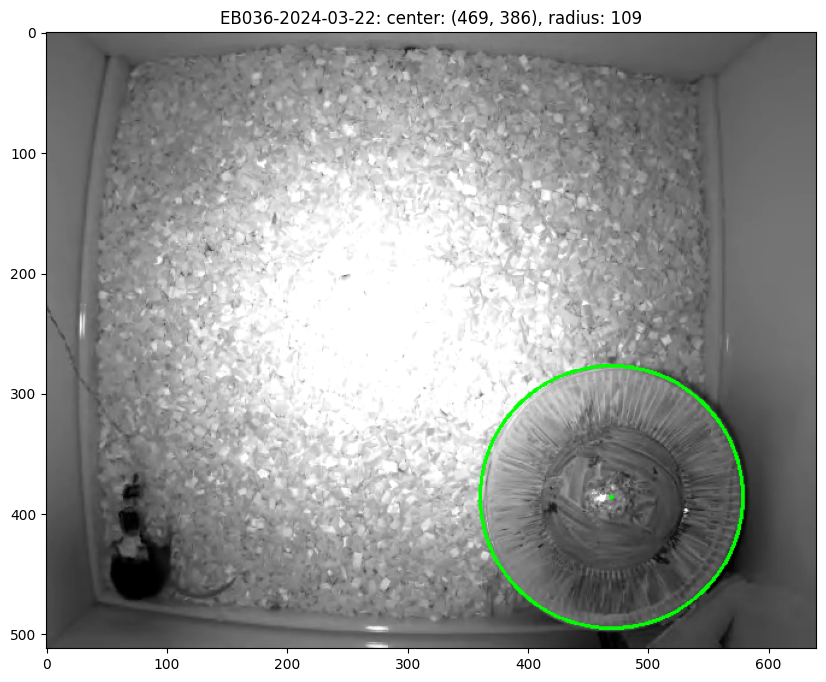

In [42]:
def get_ROI(subject_id, date):
    frame_idx = 0

    cap = cv2.VideoCapture(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4')
    while frame_idx < 3000: 

        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        
        preprocessed_frame = preprocess_frame(frame)
        circles = cv2.HoughCircles(preprocessed_frame, cv2.HOUGH_GRADIENT, dp=1.5, param1=50, param2= 20,minDist=90, minRadius=104, maxRadius=110)

        xy_list = []
        r_list = []
        if circles is not None:
            
            # Convert the (x, y) coordinates and radius of the circles to integers
            circles = np.uint16(np.around(circles))
            x, y, r = circles[0][0]
            xy_list.append((x, y))
            r_list.append(r)

        if frame_idx % 100 == 0:
            print(f"Processing frame {frame_idx}/3000")

    cap.release()
    cv2.destroyAllWindows()

    if len(xy_list) == 0:
        print("No circles found in the video.")
        return None, None, None, None
    
    # Get ROI center and radius
    center_x = int(np.median([xy[0] for xy in xy_list]))
    center_y = int(np.median([xy[1] for xy in xy_list]))
    radius = int(np.median(r_list))

    return frame, center_x, center_y, radius
        
        

def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    preprocessed_frame = cv2.medianBlur(gray_frame, 21)
    return preprocessed_frame

def plot_ROI(frame, center_x, center_y, radius):
    # Draw the circle in the image
    cv2.circle(frame, (center_x, center_y), radius, (0, 255, 0), 2)
    # Draw a rectangle at the center of the circle
    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), -1)

    #show results
    plt.figure(figsize=(10, 8))
    plt.title(f'{subject_id}-{date}: center: ({center_x}, {center_y}), radius: {radius}')
    plt.imshow(frame)

def get_mask (binned_median_positions, wheel_center_x, wheel_center_y, wheel_radius_pix):
    distances = np.sqrt((binned_median_positions[:, 0] - wheel_center_x) ** 2 + (binned_median_positions[:, 1] - wheel_center_y) ** 2)
    
    right_corner =(
        (binned_median_positions[:, 0] > wheel_center_x ) &  
        (binned_median_positions[:, 1] > wheel_center_y)
    )

    left_corner = (
        (binned_median_positions[:, 0] < wheel_center_x ) &  
        (binned_median_positions[:, 1] < wheel_center_y)
    )   

    if not subject_id == 'GB012':
        wheel_mask = distances <= wheel_radius_pix
        arena_mask = ~wheel_mask & (~right_corner)

    else:
        wheel_mask = distances <= wheel_radius_pix
        arena_mask = ~wheel_mask & (~left_corner)

    return arena_mask, wheel_mask


frame, center_x, center_y, radius = get_ROI(subject_id, date)
plot_ROI(frame, center_x, center_y, radius)
arena_mask,wheel_mask = get_mask(binned_median_positions, center_x, center_y, radius)

In [32]:
print(len(wheel_mask))
print(len(arena_mask))

60161
60161


Text(0.5, 1.0, 'EB036-2024-03-22 Arena and Wheel Masks')

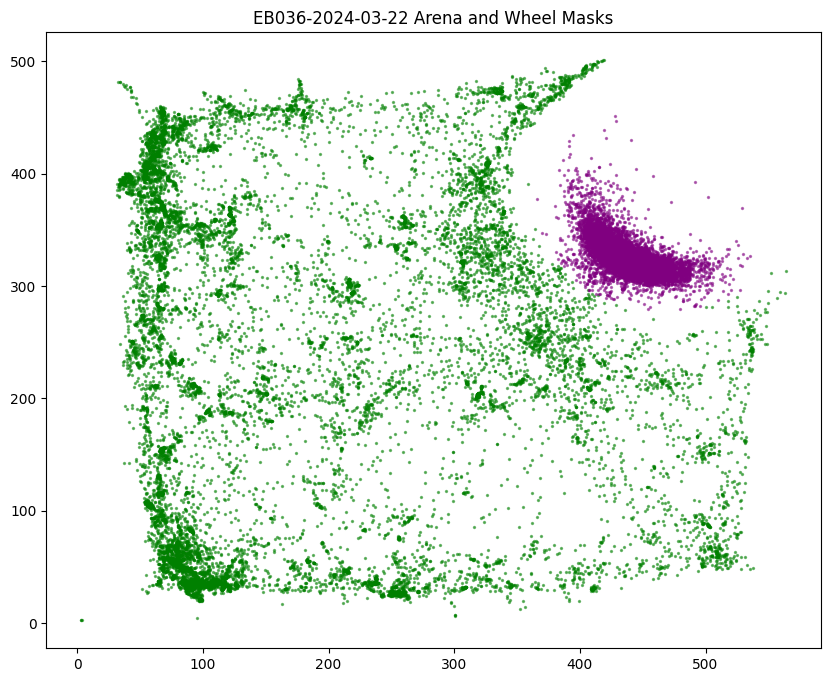

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(binned_x_median[arena_mask], binned_y_median[arena_mask], c='green', label='Arena', alpha=0.5, s=2)
plt.scatter(binned_x_median[wheel_mask], binned_y_median[wheel_mask], c='purple', label='Wheel', alpha=0.5, s=2)
plt.title(f'{subject_id}-{date} Arena and Wheel Masks')

In [46]:
# get spike hist for probe 0
spike_counts_0 = get_spike_hist(spike_times_0, spike_clusters_0, time_bins)






In [47]:
# check for spike_counts with no variance and remove them
spike_counts_0_filtered = filter_spike_counts(spike_counts_0, arena_mask, wheel_mask)







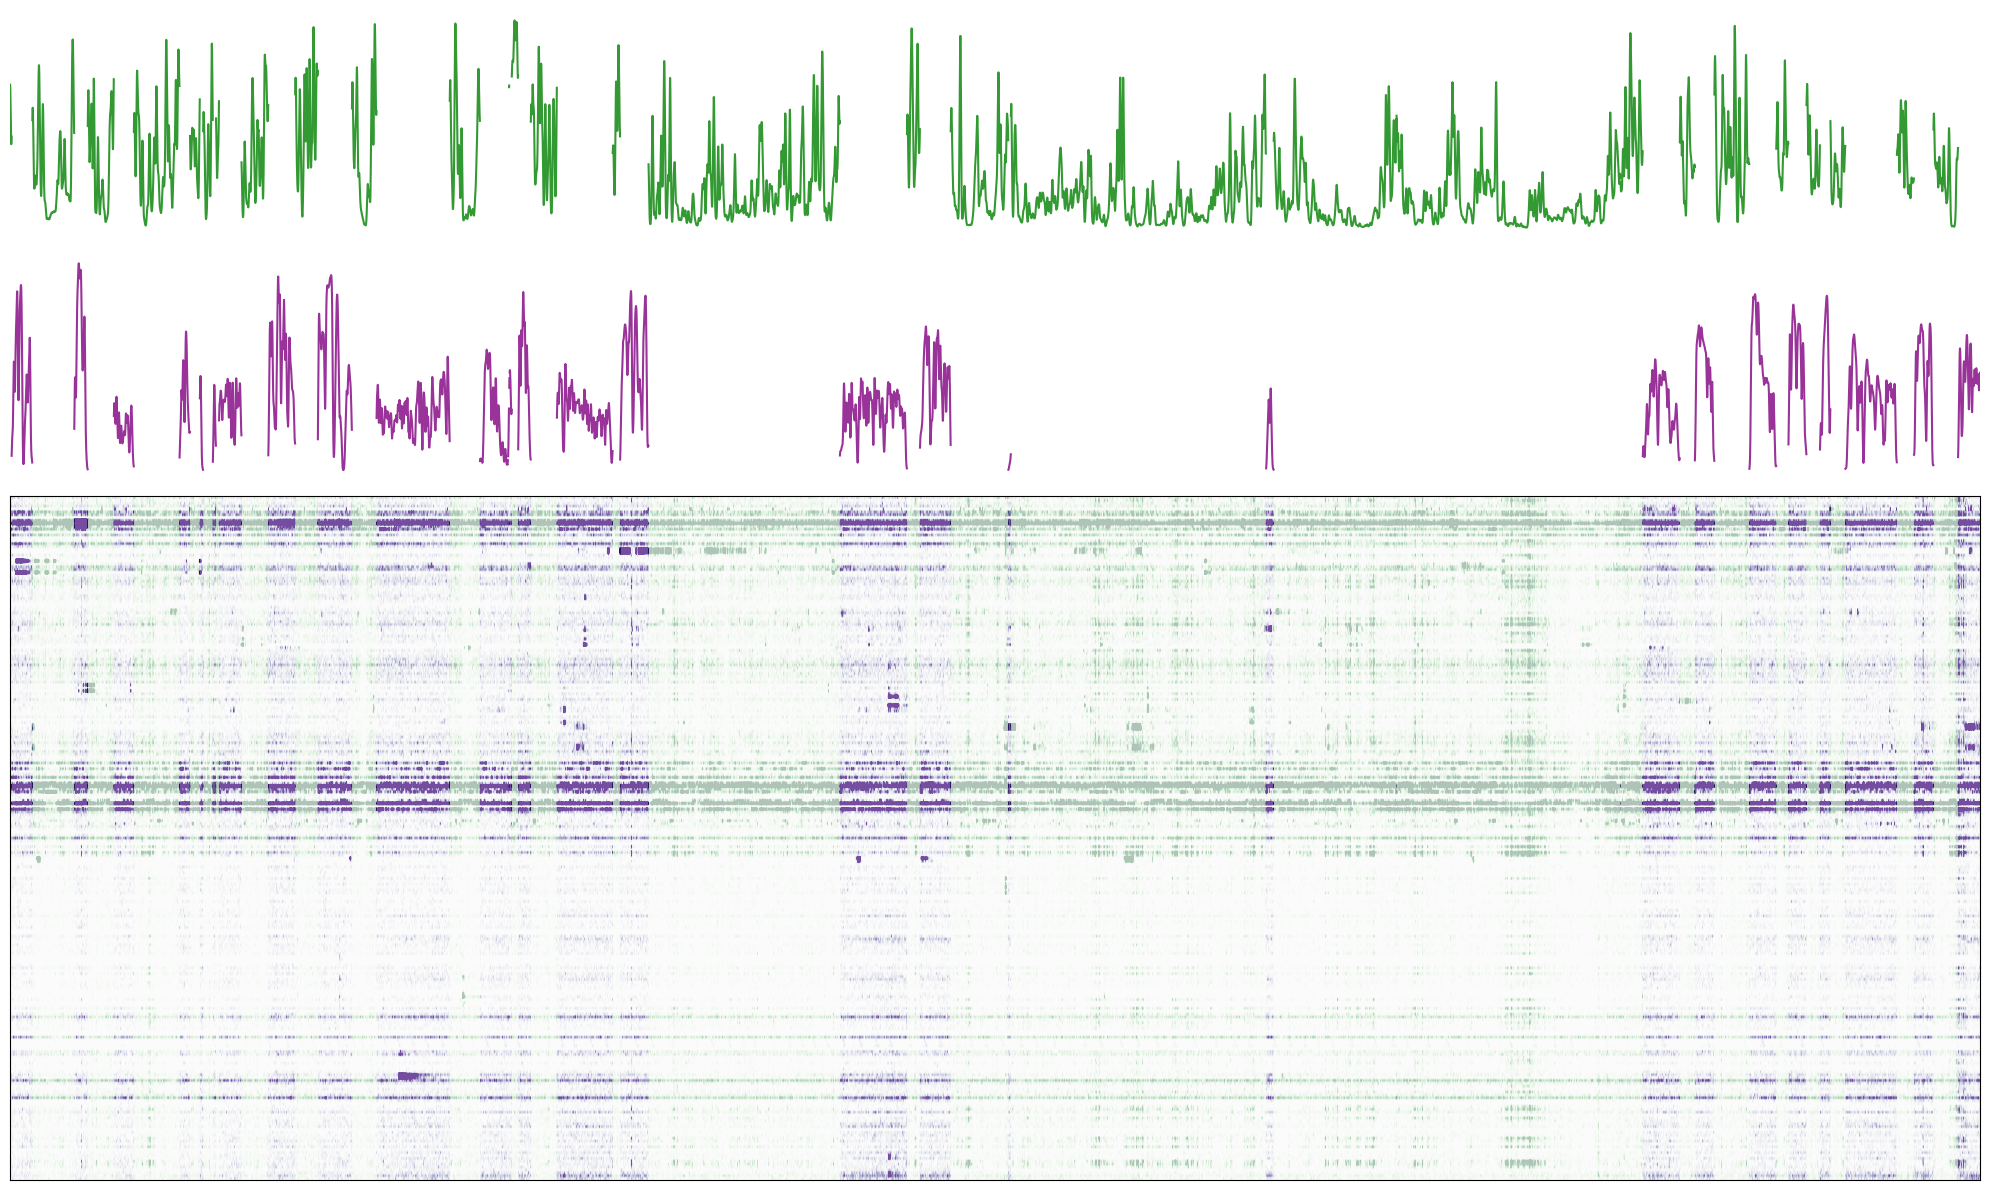

In [49]:
T_START = 0
T_END = 20000


vel_plot = velocity.copy()
vel_plot[wheel_mask] = np.nan
    
wheel_plot = wheel_velocity.copy()
wheel_plot[arena_mask] = np.nan
    
    # Create figure with three panels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12), 
                                       gridspec_kw={'height_ratios': [1, 1, 3]},
                                       sharex=True)
    
    # Plot velocities
ax1.plot(vel_plot[T_START:T_END], color='green', alpha=0.8)
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.set_ylabel('Free Running Velocity (cm/s)', color='green')

ax2.plot(wheel_plot[T_START:T_END], color='purple', alpha=0.8)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax2.set_ylabel('Wheel Running Velocity (cm/s)', color='purple')

arena_counts = np.zeros_like(spike_counts_0_filtered)
wheel_counts = np.zeros_like(spike_counts_0_filtered)

    # Fill in spike counts for each context
arena_counts[:, arena_mask] = spike_counts_0_filtered[:, arena_mask]
wheel_counts[:, wheel_mask] = spike_counts_0_filtered[:, wheel_mask]


    # Plot arena counts in green
ax3.imshow(arena_counts[:, T_START:T_END], cmap='Greens', aspect='auto', alpha=1,  vmax = np.percentile(spike_counts_0_filtered, 95))

    # Plot wheel counts in purple on top
ax3.imshow(wheel_counts[:, T_START:T_END], cmap='Purples', aspect='auto',alpha=0.7,  vmax = np.percentile(spike_counts_0_filtered, 95))

ax3.set_yticks([])
ax3.set_yticklabels([])
    #ax3.text(0.5, -0.05, '1 min', transform=ax3.transAxes, 
        #ha='center', va='top', fontsize=10)
    #ax3.set_xlabel('Time Bins')
    #ax3.text(-0.05, 0.5, '500 neurons', transform=ax3.transAxes, 
        #ha='right', va='center', fontsize=10, rotation=90)
    #ax3.set_ylabel('Neurons (sorted by correlation)')

plt.tight_layout()
plt.show()

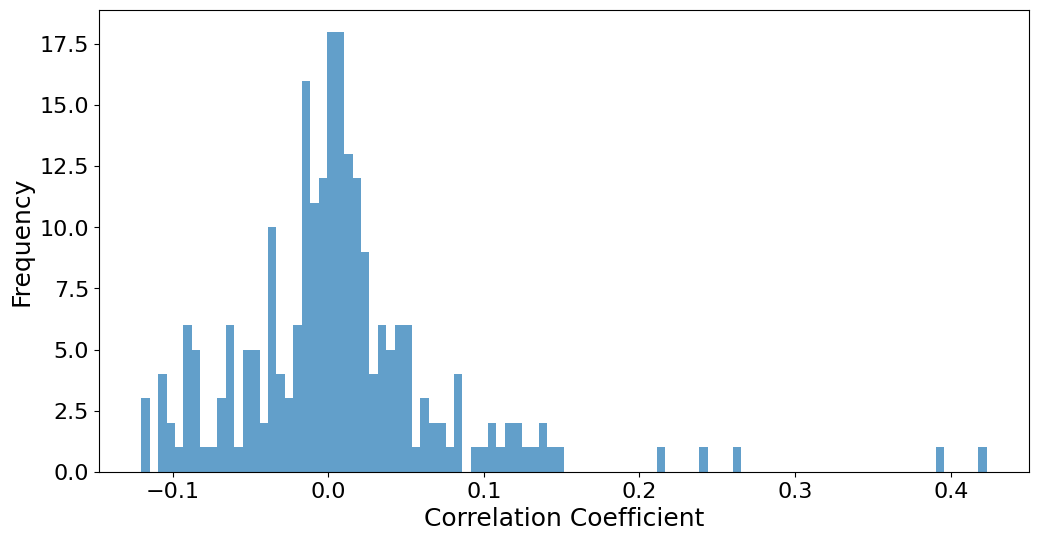

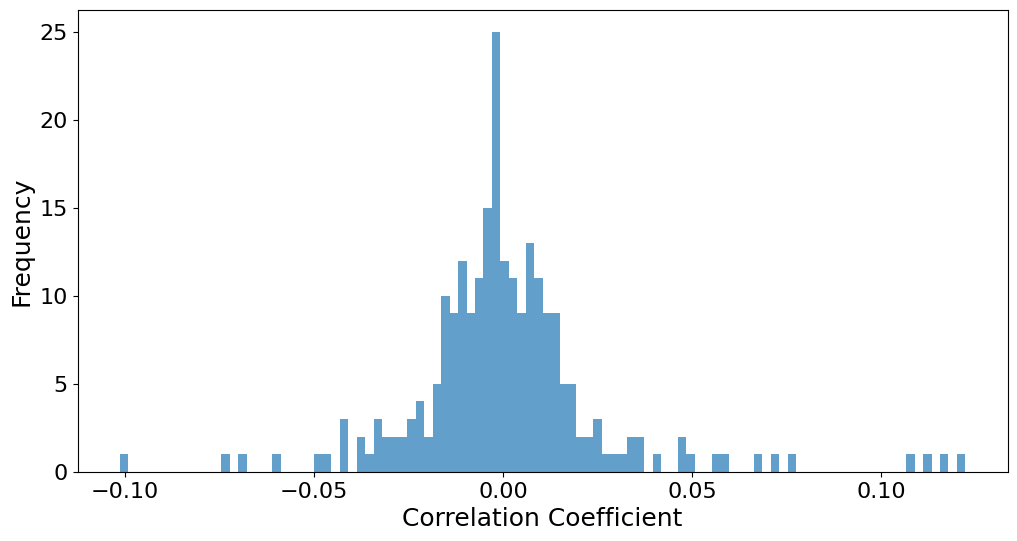

In [50]:
# Calculate correlations

arena_corrs_0, wheel_corrs_0 = get_correlations(spike_counts_0_filtered, velocity, wheel_velocity, arena_mask, wheel_mask)

    
plot_correlation_histogram(arena_corrs_0)
plt.show()

plot_correlation_histogram(wheel_corrs_0)
plt.show()






In [ ]:
np.argsort(arena_corrs_0)[::-1]


array([104,  53, 106, 452, 134,  44, 573, 611, 113, 110, 197, 115,  85,
       606, 490, 397, 427, 584, 159, 201, 538, 101, 267,  30,  32, 232,
        45, 245, 185,  84,  31,  78, 248, 574, 512, 333, 623, 160, 243,
       149, 228, 145, 144, 398, 365, 426, 223, 323, 217, 433, 224,  68,
       435, 179, 242, 107, 112, 141, 203, 290, 103, 520, 152,  83, 310,
       338, 190, 205, 407, 225,  73, 120, 488, 542, 577, 491, 429, 481,
       296, 298, 448, 476,  57, 133, 615, 204, 424, 421, 402, 170, 364,
       535, 614, 487, 459,   1, 230, 600, 272, 515, 445,  69, 360, 537,
       202, 378, 578, 277, 436, 274, 530, 234, 527, 138, 496, 620, 467,
       271,  43,  75, 219, 158, 126, 163,  61, 440,  79, 184, 287, 189,
       309, 484, 394, 485,  19, 449, 114,  42,  49, 391, 396, 453,  33,
       446, 528, 346,   5, 169, 514, 180, 153, 327, 383, 428, 102, 513,
       119, 194, 127,   7, 211, 570, 311, 409,  54, 259, 392, 283,  98,
        74, 140, 299, 475, 422, 388,  80, 139, 269, 592, 300, 25

Correlation between free and wheel running neurons: 0.1948837230523657


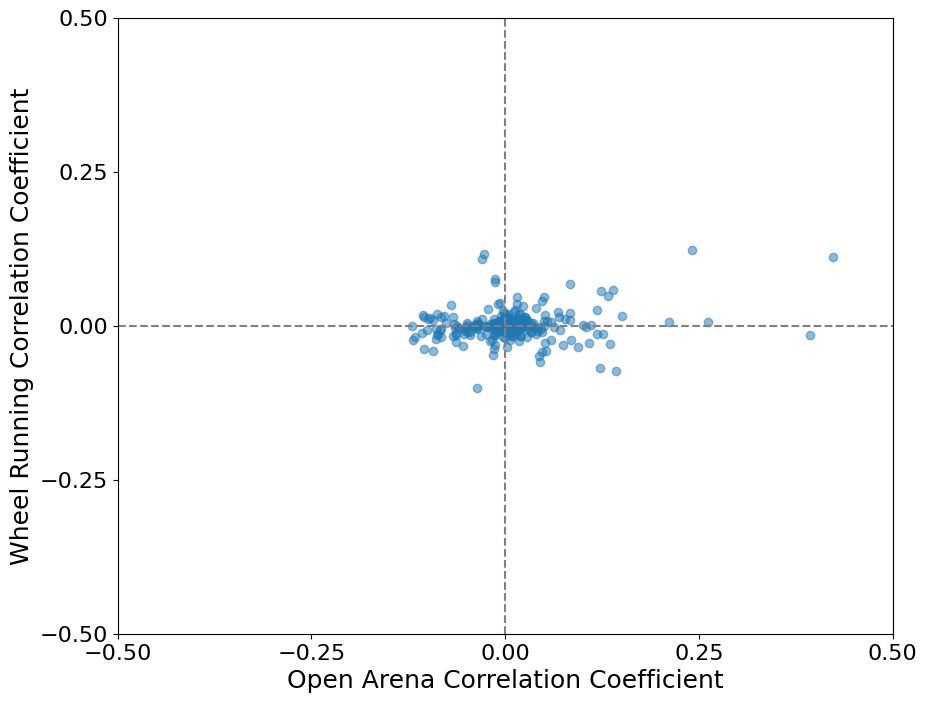

In [51]:
plot_wheel_arena_corr(arena_corrs_0, wheel_corrs_0)



In [52]:
n_splits = 2
train_corr_arena_0, test_corr_arena_0, train_test_corr_arena_0,train_corr_wheel_0, test_corr_wheel_0, train_test_corr_wheel_0 = cross_validate_correlations(spike_counts_0_filtered, n_splits,pos_wheel_mask, velocity, wheel_velocity)
plot_cross_validation(n_splits,train_corr_arena_0, test_corr_arena_0, train_test_corr_arena_0,train_corr_wheel_0, test_corr_wheel_0, train_test_corr_wheel_0)

print(f'Correlation between train and test: {train_test_corr_arena_0}')
print(f'Correlation between train and test: {train_test_corr_wheel_0}') 

IndexError: boolean index did not match indexed array along dimension 1; dimension is 25584 but corresponding boolean dimension is 18520

In [ ]:
subjects = ['AV043', 'EB036', 'EB037', 'GB011', 'GB012']
dates = [
    # March
    '2024-03-04',
    '2024-03-05',
    
    '2024-03-11',
    '2024-03-12',
    '2024-03-13',
    '2024-03-14',
    '2024-03-15',
    '2024-03-19',
    '2024-03-20',
    '2024-03-21',
    '2024-03-22',
    '2024-03-25',
    '2024-03-26',
    # May
    '2024-05-09',
    '2024-05-10',
    '2024-05-14',
    '2024-05-15',
    '2024-05-16',
    '2024-05-17',
    # June
    '2024-06-19',
    '2024-06-20',
    '2024-06-21',
    '2024-06-25',
    # July
    '2024-07-11',
    '2024-07-12',
    '2024-07-16'
]
    
n_neurons = spike_counts_0_filtered.shape[0]
null_wheel = np.zeros((N, n_neurons))
null_arena = np.zeros((N, n_neurons))
i = 0

for date  in dates:
    for subject_id in subjects:
        try:
            print(f'Loading data for {subject_id} on {date}')

            data = load_specific_experiment_data(subject_id, date)
            exp_path, exp_num = get_experiment_path(data)
            delay, timestamps = get_timestamps(subject_id, date, exp_num, exp_path)

            dlc_df, scorer = get_DLC_data(subject_id, date, delay)
            median_position_df, x_medians, y_medians = calculate_median_position(dlc_df, scorer)
            velocity = calculate_velocity(median_position_df)
            binned_velocity = bin_velocity(velocity, time_bins, timestamps, delay)

            rotary_timestamps, rotary_speed = get_rotary_metadata(exp_path)
            downsampled_timestamps, wheel_velocity = calculate_wheel_velocity(rotary_timestamps, rotary_speed, time_bins)
            binned_wheel_velocity = bin_wheel_velocity(wheel_velocity, downsampled_timestamps, time_bins)

            binned_x_median, binned_y_median, binned_median_positions = bin_median_positions(x_medians, y_medians, time_bins, timestamps, delay)
            vel_arena_mask, vel_wheel_mask = get_vel_masks(binned_wheel_velocity)
            pos_arena_mask, pos_wheel_mask = get_pos_masks(binned_median_positions, vel_wheel_mask)
            rand_corr_wheel, rand_corr_arena  = get_correlations(spike_counts_0_filtered, binned_velocity, binned_wheel_velocity, pos_arena_mask, pos_wheel_mask)
            null_wheel[i] = rand_corr_wheel
            null_arena[i] = rand_corr_arena
            i += 1

        except Exception as e:
            print(f"Error processing {subject_id} on {date}: {e}")
            





Loading data for AV043 on 2024-03-04
Loading data for EB036 on 2024-03-04
Error processing EB036 on 2024-03-04: index 0 is out of bounds for axis 0 with size 0
Loading data for EB037 on 2024-03-04
Error processing EB037 on 2024-03-04: index 0 is out of bounds for axis 0 with size 0
Loading data for GB011 on 2024-03-04
Error processing GB011 on 2024-03-04: index 0 is out of bounds for axis 0 with size 0
Loading data for GB012 on 2024-03-04
Error processing GB012 on 2024-03-04: index 0 is out of bounds for axis 0 with size 0
Loading data for AV043 on 2024-03-05
Loading data for EB036 on 2024-03-05
Error processing EB036 on 2024-03-05: index 0 is out of bounds for axis 0 with size 0
Loading data for EB037 on 2024-03-05
Error processing EB037 on 2024-03-05: index 0 is out of bounds for axis 0 with size 0
Loading data for GB011 on 2024-03-05
Error processing GB011 on 2024-03-05: index 0 is out of bounds for axis 0 with size 0
Loading data for GB012 on 2024-03-05
Error processing GB012 on 20

Text(0.5, 1.0, 'Null distribution of wheel running correlation for neuron 12')

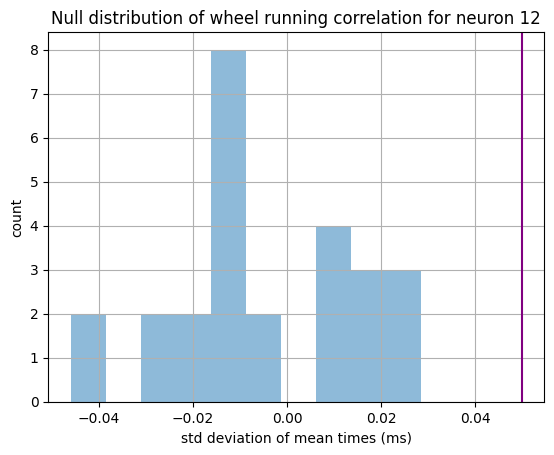

In [ ]:

neuron = randint(0, n_neurons)
plt.hist(null_wheel[:, neuron], alpha=0.5, label='wheel running')
plt.axvline(wheel_corrs_0[neuron], color='purple')
plt.xlabel('std deviation of mean times (ms)')
plt.ylabel('count')
plt.grid(True)
plt.title(f'Null distribution of wheel running correlation for neuron {neuron}')




In [ ]:
# compute the p-values
p_values_wheel = np.zeros((n_neurons))
for n in range(n_neurons):
    p_values_wheel[n] = np.sum(null_wheel[:, n]) >= wheel_corrs_0[n] / null_wheel.shape[0] 

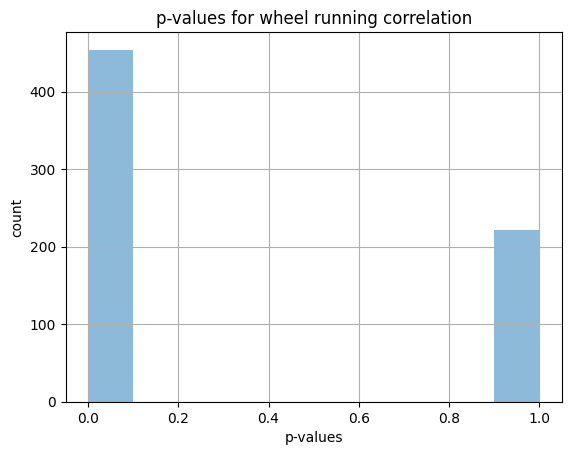

In [ ]:
plt. hist(p_values_wheel, alpha=0.5, density=False)
plt.xlabel('p-values')
plt.ylabel('count')
plt.title('p-values for wheel running correlation')
plt.grid(True)
plt.show()

In [ ]:
spike_count_scaled = StandardScaler().fit_transform(spike_counts.T).T
pca = PCA(n_components=len(spike_counts))
pca.fit(spike_count_scaled.T)
eigenvectors = pca.transform(spike_count_scaled.T).T
eigenvalues = pca.explained_variance_

print(f'PCA eigenvalues: {eigenvalues[:10]}')





PCA eigenvalues: [22.17267472 11.0224477   8.29512494  5.259602    3.79592585  3.09240933
  2.74503701  2.50084438  2.33118462  2.10839285]


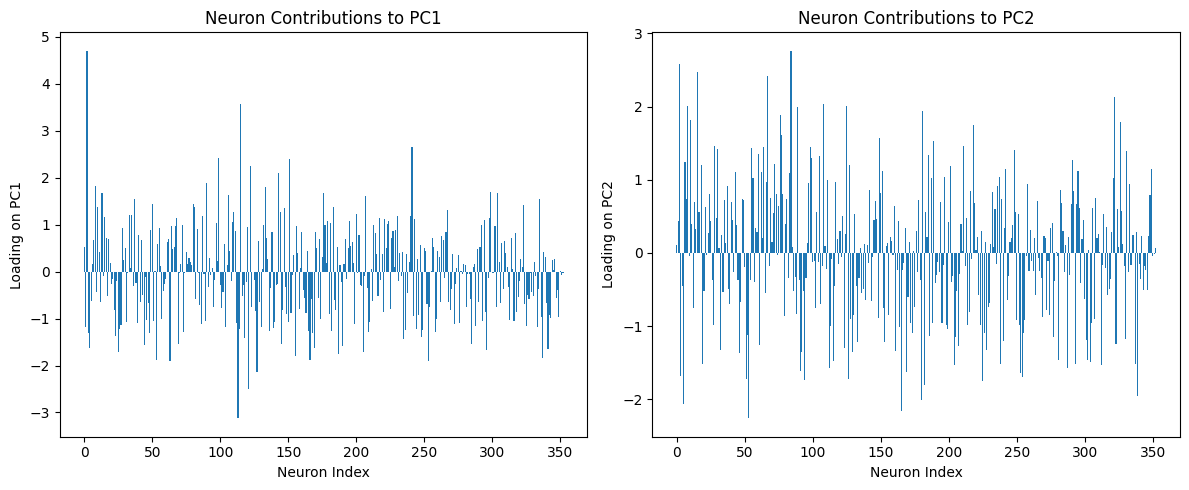

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(eigenvectors[:, 0])), eigenvectors[:, 0])
plt.xlabel('Neuron Index')
plt.ylabel('Loading on PC1')
plt.title('Neuron Contributions to PC1')

plt.subplot(1, 2, 2)
plt.bar(range(len(eigenvectors[:, 1])), eigenvectors[:, 1])
plt.xlabel('Neuron Index')
plt.ylabel('Loading on PC2')
plt.title('Neuron Contributions to PC2')

plt.tight_layout()
plt.show()

In [ ]:
print(f'length time bins: {len(time_bins)}')
print(f'length downsampled_timestamps: {len(downsampled_timestamps)}')

length time bins: 50145
length downsampled_timestamps: 50145
